<a href="https://colab.research.google.com/github/daeunni/Statistical_DL/blob/main/HW/HW7_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **HW7**

### 1. VAE에서 normal  latent dimension을 증가시켜 변화를 점검하여 해설할 것


In [19]:
import tensorflow as tf
from tensorflow.keras import backend as k
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
import numpy as np
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Lambda ,Reshape, Conv2DTranspose
import matplotlib.pyplot as plt
from scipy.stats import norm

In [102]:
img_shape=(28,28,1)  # input 이미지 차원
batch_size=16
latent_dim=10    # 잠재 변수 차원


############################### Encoder #########################################3
input_img = Input(shape=img_shape)
x = Conv2D(32,3,padding='same', strides=2, activation='relu')(input_img)
x = Conv2D(64,3, padding='same', strides=2, activation='relu')(x)   # 픽셀의 특성을 추출함
shape = k.int_shape(x)
x = Flatten()(x)
x = Dense(32, activation='relu')(x)   

# latent variable (2차원)
z_mean= Dense(latent_dim)(x)  # 잠재변수 z의 평균
z_log_var= Dense(latent_dim)(x)  # 잠재변수 z의 분산


## 입실론 (error)에 해당하는 부분 sampling
def sampling(args):
    z_mean, z_log_var = args
    batch = k.shape(z_mean)[0]
    dim = k.int_shape(z_mean)[1]
    epsilon = tf.random.normal(shape=(batch,dim))   # 표준 정규분포에서 추출
    return z_mean + tf.exp(0.5*z_log_var) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,)) ([z_mean, z_log_var])   # keras에 built-in 되어있지 않아 Lambda를 호출해 은닉층으로 추가

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 14, 14, 32)   320         input_7[0][0]                    
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 7, 7, 64)     18496       conv2d_6[0][0]                   
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 3136)         0           conv2d_7[0][0]                   
___________________________________________________________________________________________

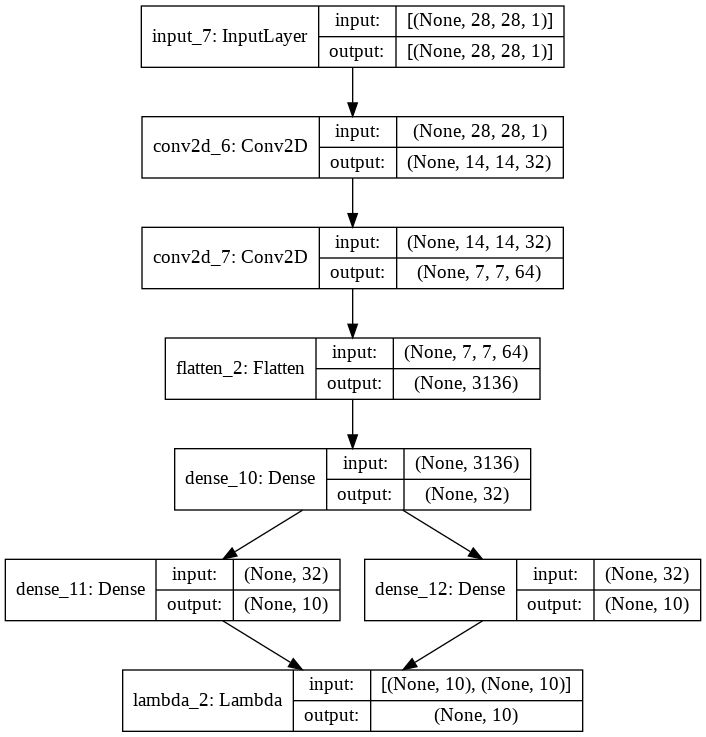

In [103]:
encoder=Model(input_img,[z_mean, z_log_var, z])
encoder.summary()
plot_model(encoder,show_shapes=True)

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
dense_13 (Dense)             (None, 3136)              34496     
_________________________________________________________________
reshape_3 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 1)         289       
Total params: 90,177
Trainable params: 90,177
Non-trainable params: 0
______________________________________________________

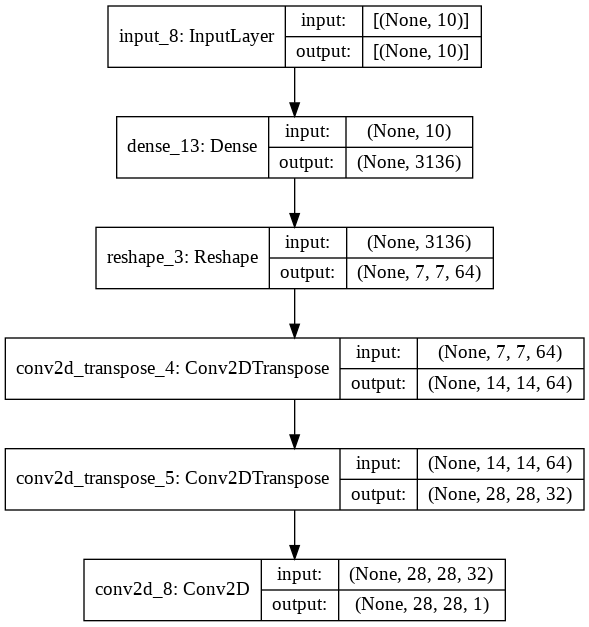

In [104]:
############################# Decoder #############################################
latent_input= Input(shape=(latent_dim,))

x= Dense(np.prod(shape[1:]), activation='relu')(latent_input)
x= Reshape(shape[1:])(x)

x= Conv2DTranspose(64,3,padding='same',strides=2,activation='relu')(x)   # upsampling의 기능 
x= Conv2DTranspose(32,3,padding='same',strides=2,activation='relu')(x)
output= Conv2D(1,3, padding='same',activation='sigmoid')(x)  # 원래 이미지 크기로 되돌려놓기!

decoder=Model(latent_input, output)
f_output=decoder(encoder(input_img)[2])  # 최종 출력은 input과 동일한 (28, 28, 1) 3d tensor 출력

decoder.summary()
plot_model(decoder, show_shapes=True)

In [105]:
################# VAE 정의 #########################33
vae=Model(input_img, f_output)    # 인코더의 input, 디코더의 output
vae.summary()

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
model_12 (Functional)        [(None, 10), (None, 10),  119860    
_________________________________________________________________
model_13 (Functional)        (None, 28, 28, 1)         90177     
Total params: 210,037
Trainable params: 210,037
Non-trainable params: 0
_________________________________________________________________


In [106]:
# 손실 추가 정의 
inference_loss=1+z_log_var-tf.square(z_mean)-tf.exp(z_log_var)
inference_loss=k.sum(inference_loss, axis=-1)*-0.5/(input_img.shape[1]*input_img.shape[1])

vae.add_loss(k.mean(inference_loss))   # add_loss를 이용해 추론손실 정의 
vae.compile(loss='mse', optimizer='rmsprop')

# Fitting 

In [107]:
## MNIST data load
from tensorflow.keras.datasets import mnist

(x_train,_),(x_test,y_test)=mnist.load_data()
image_size = x_train.shape[1]

x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])

x_train = x_train.astype('float32') / 255   # 표준화 
x_test = x_test.astype('float32') / 255

In [72]:
print(x_train.shape, x_test.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1)


In [108]:
vae.fit(x_train, x_train, epochs=10, shuffle=True, batch_size=batch_size, validation_data=(x_test,x_test))   # 잠재변수 10차원일 때

Epoch 1/10
3750/3750 [==============================] - 24s 6ms/step - loss: 0.0502 - val_loss: 0.0436
Epoch 2/10
3750/3750 [==============================] - 23s 6ms/step - loss: 0.0428 - val_loss: 0.0417
Epoch 3/10
3750/3750 [==============================] - 23s 6ms/step - loss: 0.0415 - val_loss: 0.0408
Epoch 4/10
3750/3750 [==============================] - 23s 6ms/step - loss: 0.0407 - val_loss: 0.0404
Epoch 5/10
3750/3750 [==============================] - 23s 6ms/step - loss: 0.0398 - val_loss: 0.0391
Epoch 6/10
3750/3750 [==============================] - 23s 6ms/step - loss: 0.0389 - val_loss: 0.0385
Epoch 7/10
3750/3750 [==============================] - 23s 6ms/step - loss: 0.0385 - val_loss: 0.0384
Epoch 8/10
3750/3750 [==============================] - 23s 6ms/step - loss: 0.0383 - val_loss: 0.0378
Epoch 9/10
3750/3750 [==============================] - 23s 6ms/step - loss: 0.0381 - val_loss: 0.0377
Epoch 10/10
3750/3750 [==============================] - 23s 6ms/step - l

In [73]:
vae.fit(x_train, x_train, epochs=10, shuffle=True, batch_size=batch_size, validation_data=(x_test,x_test))   # 잠재변수 3차원일 때 

Epoch 1/10
3750/3750 [==============================] - 24s 6ms/step - loss: 0.0511 - val_loss: 0.0468
Epoch 2/10
3750/3750 [==============================] - 23s 6ms/step - loss: 0.0459 - val_loss: 0.0451
Epoch 3/10
3750/3750 [==============================] - 22s 6ms/step - loss: 0.0446 - val_loss: 0.0443
Epoch 4/10
3750/3750 [==============================] - 23s 6ms/step - loss: 0.0440 - val_loss: 0.0437
Epoch 5/10
3750/3750 [==============================] - 22s 6ms/step - loss: 0.0436 - val_loss: 0.0431
Epoch 6/10
3750/3750 [==============================] - 23s 6ms/step - loss: 0.0433 - val_loss: 0.0431
Epoch 7/10
3750/3750 [==============================] - 23s 6ms/step - loss: 0.0431 - val_loss: 0.0429
Epoch 8/10
3750/3750 [==============================] - 23s 6ms/step - loss: 0.0429 - val_loss: 0.0431
Epoch 9/10
3750/3750 [==============================] - 23s 6ms/step - loss: 0.0428 - val_loss: 0.0429
Epoch 10/10
3750/3750 [==============================] - 22s 6ms/step - l

> loss 가 더 적다 (학습에 도움을 준다)



# Plotting

In [97]:
n_to_show = 1000  # 5000개의 관측치를 plotting
grid_size = 20
figsize = 8

# x_test에서 이미지 선택
example_idx = np.random.choice(range(len(x_test)), n_to_show)   # 5000개 선택
example_images = x_test[example_idx]
example_labels = y_test[example_idx]

encoder = Model(input_img, z_mean)
z_points = np.array(encoder.predict(example_images))

In [98]:
import pandas as pd
axis = pd.DataFrame(z_points[:, 0], columns=['x'])
axis['y'] = z_points[:, 1]
axis['z'] = z_points[:, 2]
axis['label'] = example_labels

In [99]:
axis.head()

,x,y,z,label
0,-0.476911,-0.781112,-0.694533,4
1,0.101314,0.615213,0.597546,2
2,0.426196,-0.051949,1.145287,3
3,1.668180,1.446591,-2.033998,7
4,1.687392,0.304073,-0.609473,9


In [100]:
# 784차원 입력공간에서 2차원 잠재공간으로 변환
import plotly.express as px
fig = px.scatter_3d(axis, x='x', y='y', z='z',
              color='label')
fig.show()

### 잠재변수 차원을 늘리면 좋은점 
- 이미지의 상세 정보를 충분히 인코딩 가능 (복잡한 이미지에 효과적임)
- 시각화를 했을 때 cluster가 비교적 뭉쳐있는 모습

----------------------



### 2. VAE에서 channel수를 32-->64-->128로 증가시켜 비교할 것

Model: "model_117"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_110 (InputLayer)          [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_115 (Conv2D)             (None, 14, 14, 32)   320         input_110[0][0]                  
__________________________________________________________________________________________________
conv2d_116 (Conv2D)             (None, 7, 7, 64)     18496       conv2d_115[0][0]                 
__________________________________________________________________________________________________
conv2d_117 (Conv2D)             (None, 3, 3, 128)    73856       conv2d_116[0][0]                 
__________________________________________________________________________________________

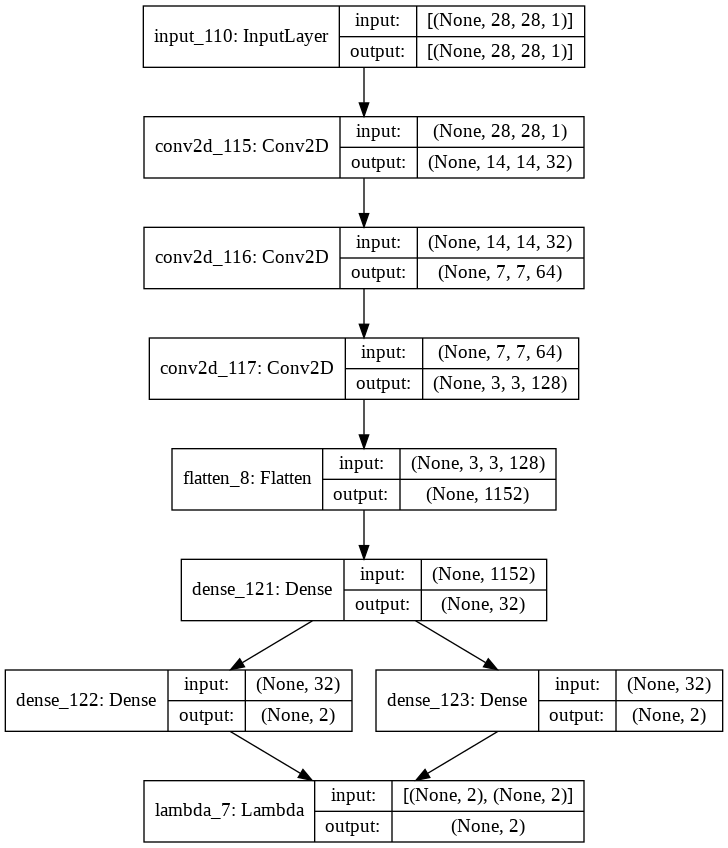

In [223]:
img_shape=(28,28,1)
batch_size=16
latent_dim=2

input_img=layers.Input(shape=img_shape)
x=layers.Conv2D(32,3,padding='same', strides=2, activation='relu')(input_img)
x=layers.Conv2D(64,3, padding='same', strides=2, activation='relu')(x)
x=layers.Conv2D(128,3, strides=2, activation='relu')(x)
shape=k.int_shape(x)
x=layers.Flatten()(x)
x=layers.Dense(32, activation='relu')(x)

# latent variable
z_mean=layers.Dense(latent_dim)(x)  # 잠재변수 z의 평균
z_log_var=layers.Dense(latent_dim)(x)  # 잠재변수 z의 분산

def sampling(args):
    z_mean,z_log_var=args
    batch=k.shape(z_mean)[0]
    dim=k.int_shape(z_mean)[1]
    epsilon=tf.random.normal(shape=(batch,dim))
    return z_mean+tf.exp(0.5*z_log_var)*epsilon
z=layers.Lambda(sampling,output_shape=(latent_dim,))([z_mean,z_log_var])   # keras에 built-in 되어있지 않아 Lambda를 호출해 은닉층으로 추가

encoder=Model(input_img,[z_mean, z_log_var, z])
encoder.summary()
plot_model(encoder,show_shapes=True)

Model: "model_121"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_114 (InputLayer)       [(None, 2)]               0         
_________________________________________________________________
dense_127 (Dense)            (None, 1152)              3456      
_________________________________________________________________
reshape_99 (Reshape)         (None, 3, 3, 128)         0         
_________________________________________________________________
conv2d_transpose_240 (Conv2D (None, 7, 7, 128)         147584    
_________________________________________________________________
conv2d_transpose_241 (Conv2D (None, 14, 14, 64)        73792     
_________________________________________________________________
conv2d_transpose_242 (Conv2D (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_121 (Conv2D)          (None, 28, 28, 1)         28

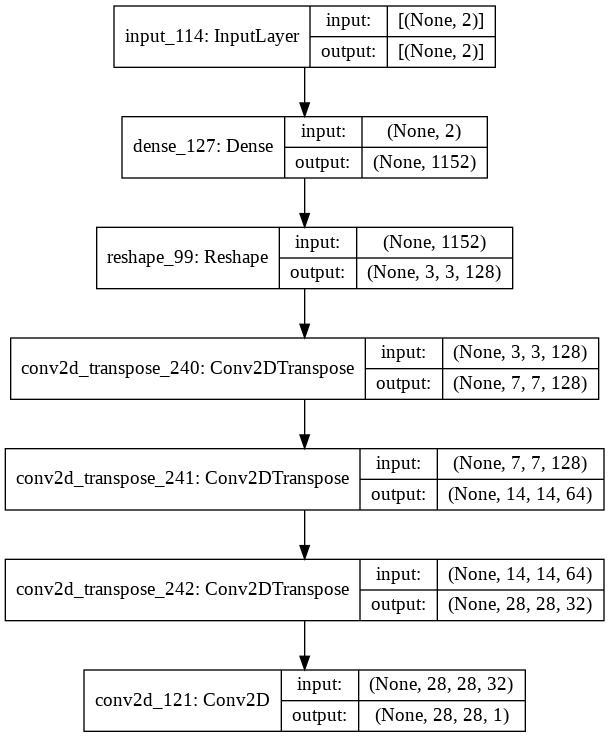

In [227]:
latent_input=layers.Input(shape=(latent_dim,))

x=layers.Dense(np.prod(shape[1:]), activation='relu')(latent_input)
x=layers.Reshape(shape[1:])(x)

### 디코더 모델 변형!!!! 
x=layers.Conv2DTranspose(128,3,strides=2,activation='relu')(x)
x=layers.Conv2DTranspose(64,3,padding='same',strides=2,activation='relu')(x)
x=layers.Conv2DTranspose(32,3,padding='same',strides=2,activation='relu')(x)

output=layers.Conv2D(1,3, padding='same',activation='sigmoid')(x)
decoder=Model(latent_input,output)
decoder.summary()
plot_model(decoder, show_shapes=True)

In [228]:
f_output=decoder(encoder(input_img)[2])  # 최종 출력은 input과 동일한 (28, 28, 1) 3d tensor 출력
vae=Model(input_img, f_output)  
vae.summary()

Model: "model_122"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_110 (InputLayer)       [(None, 28, 28, 1)]       0         
_________________________________________________________________
model_117 (Functional)       [(None, 2), (None, 2), (N 129700    
_________________________________________________________________
model_121 (Functional)       (None, 28, 28, 1)         243585    
Total params: 373,285
Trainable params: 373,285
Non-trainable params: 0
_________________________________________________________________


In [229]:
inference_loss=1+z_log_var-tf.square(z_mean)-tf.exp(z_log_var)
inference_loss=k.sum(inference_loss, axis=-1)*-0.5/(input_img.shape[1]*input_img.shape[1])

vae.add_loss(k.mean(inference_loss))   # add_loss를 이용해 추론손실 정의 
vae.compile(loss='mse', optimizer='rmsprop')

from tensorflow.keras.datasets import mnist

(x_train,_),(x_test,y_test)=mnist.load_data()
image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

vae.fit(x_train, x_train, epochs=10, shuffle=True, batch_size=batch_size, validation_data=(x_test,x_test))   # stried 7

Epoch 1/10
3750/3750 [==============================] - 30s 8ms/step - loss: 0.0538 - val_loss: 0.0502
Epoch 2/10
3750/3750 [==============================] - 29s 8ms/step - loss: 0.0491 - val_loss: 0.0484
Epoch 3/10
3750/3750 [==============================] - 28s 8ms/step - loss: 0.0479 - val_loss: 0.0478
Epoch 4/10
3750/3750 [==============================] - 28s 8ms/step - loss: 0.0473 - val_loss: 0.0471
Epoch 5/10
3750/3750 [==============================] - 29s 8ms/step - loss: 0.0469 - val_loss: 0.0473
Epoch 6/10
3750/3750 [==============================] - 28s 8ms/step - loss: 0.0466 - val_loss: 0.0470
Epoch 7/10
3750/3750 [==============================] - 28s 8ms/step - loss: 0.0464 - val_loss: 0.0466
Epoch 8/10
3750/3750 [==============================] - 29s 8ms/step - loss: 0.0463 - val_loss: 0.0463
Epoch 9/10
3750/3750 [==============================] - 28s 8ms/step - loss: 0.0461 - val_loss: 0.0461
Epoch 10/10
3750/3750 [==============================] - 29s 8ms/step - l

학습이 더 잘되는 모습이다 !!


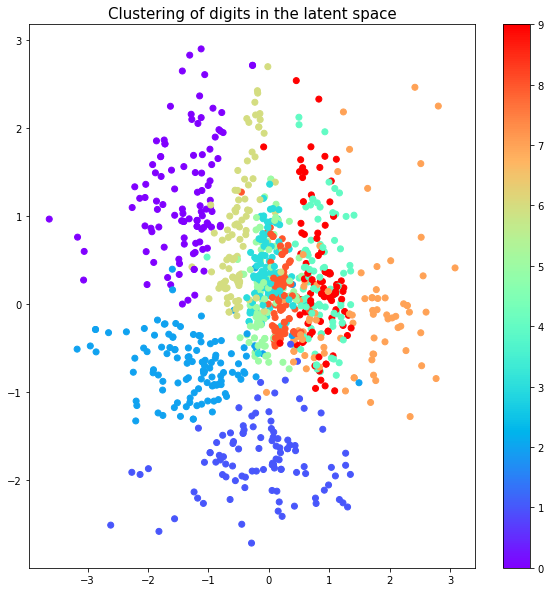

In [230]:
# 784차원 입력공간에서 2차원 잠재공간으로 변환
n_to_show = 1000  # 5000개의 관측치를 plotting
grid_size = 20
figsize = 8

# x_test에서 이미지 선택
example_idx = np.random.choice(range(len(x_test)), n_to_show)   # 5000개 선택
example_images = x_test[example_idx]
example_labels = y_test[example_idx]

encoder = Model(input_img, z_mean)
z_points = np.array(encoder.predict(example_images))

plt.figure(figsize=(10, 10))
plt.scatter(z_points[:, 0], z_points[:, 1], c=example_labels, cmap='rainbow')
plt.colorbar()
plt.title('Clustering of digits in the latent space', fontsize=15)
plt.show()

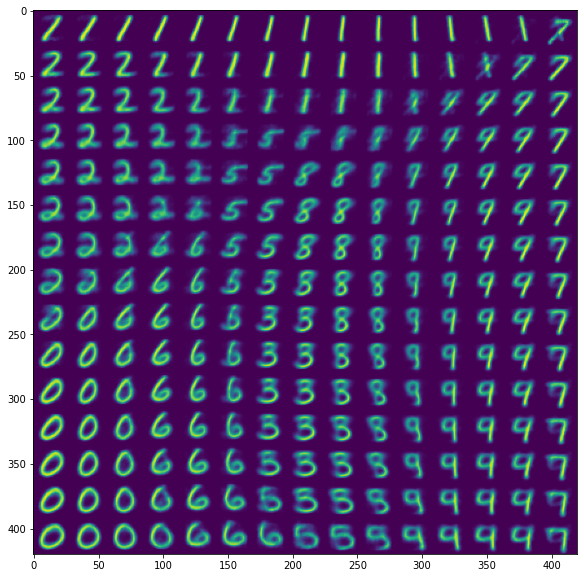

In [231]:
import matplotlib.pyplot as plt
from scipy.stats import norm
n=15   # 15개의 잠재변수 
image_size=28
figure=np.zeros((image_size*n,image_size*n))

z_x=norm.ppf(np.linspace(0.05,0.95,n))   # norm.ppf : 표준정규분포 확률변수 값 추출
z_y=norm.ppf(np.linspace(0.05,0.95,n))

for i,y in enumerate(z_y):
    for j, x in enumerate(z_x):
        z_sample=np.array([[x,y]])
        z_sample=np.tile(z_sample, batch_size).reshape(batch_size,2)
        x_decoded=decoder.predict(z_sample)
        digit=x_decoded[0].reshape(image_size, image_size)
        figure[i*image_size:(i+1)*image_size, j*image_size:(j+1)*image_size]=digit

plt.figure(figsize=(10,10))
plt.imshow(figure)
plt.show()   # 연속적으로 움직이는 숫자의 연속적인 분포 출력 

### 채널수를 늘리면 좋은점 
- 디코더에 있는 마지막 층의 출력이 인코더의 입력과 크기만 같으면 됨!
- 인코더의 합성곱 층이 저수준 픽셀을 고수준 특성으로 변환하고, 디코더는 반대로 잠재공간에 있는 고수준 특성을 저수준 픽셀로 변환함. 
> 인코더의 합성곱 채널 수 증가가 고수준 특성을 반환할 수 있도록 하여 효율적인 학습을 할 수 있었던 것으로 보임


------------------------------------------------------

### 3.  1+2를 동시에 적용하여 변화를 논의할 것
- latent dimension : 10
- channel 수 32>64>128 증가

Model: "model_124"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_115 (InputLayer)          [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_122 (Conv2D)             (None, 14, 14, 32)   320         input_115[0][0]                  
__________________________________________________________________________________________________
conv2d_123 (Conv2D)             (None, 7, 7, 64)     18496       conv2d_122[0][0]                 
__________________________________________________________________________________________________
conv2d_124 (Conv2D)             (None, 3, 3, 128)    73856       conv2d_123[0][0]                 
__________________________________________________________________________________________

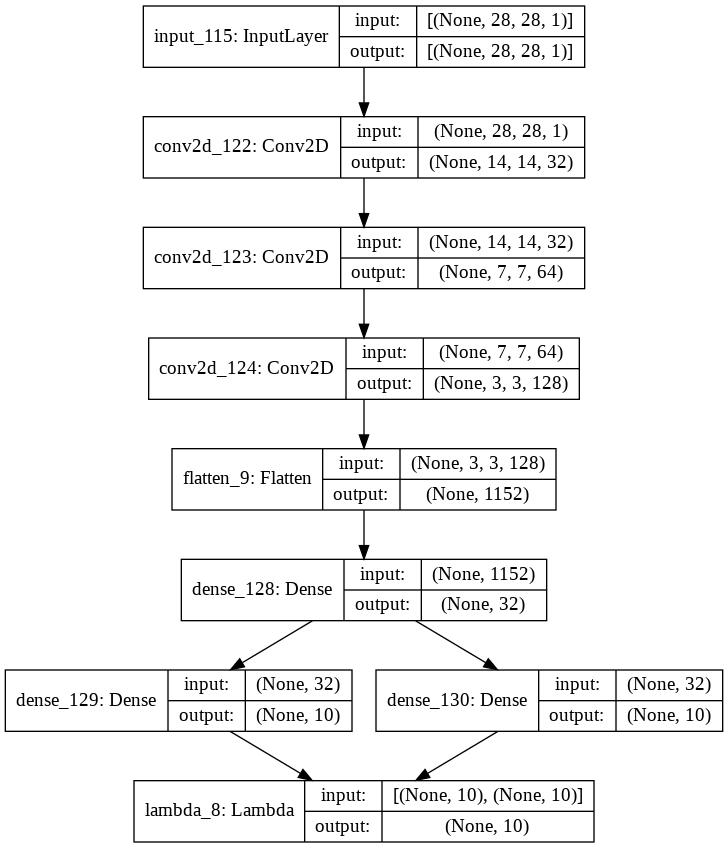

In [232]:
img_shape=(28,28,1)
batch_size=16
latent_dim=10

input_img=layers.Input(shape=img_shape)
x=layers.Conv2D(32,3,padding='same', strides=2, activation='relu')(input_img)
x=layers.Conv2D(64,3, padding='same', strides=2, activation='relu')(x)
x=layers.Conv2D(128,3, strides=2, activation='relu')(x)
shape=k.int_shape(x)
x=layers.Flatten()(x)
x=layers.Dense(32, activation='relu')(x)

# latent variable
z_mean=layers.Dense(latent_dim)(x)  # 잠재변수 z의 평균
z_log_var=layers.Dense(latent_dim)(x)  # 잠재변수 z의 분산

def sampling(args):
    z_mean,z_log_var=args
    batch=k.shape(z_mean)[0]
    dim=k.int_shape(z_mean)[1]
    epsilon=tf.random.normal(shape=(batch,dim))
    return z_mean+tf.exp(0.5*z_log_var)*epsilon
z=layers.Lambda(sampling,output_shape=(latent_dim,))([z_mean,z_log_var])   # keras에 built-in 되어있지 않아 Lambda를 호출해 은닉층으로 추가

encoder=Model(input_img,[z_mean, z_log_var, z])
encoder.summary()
plot_model(encoder,show_shapes=True)

Model: "model_125"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_116 (InputLayer)       [(None, 10)]              0         
_________________________________________________________________
dense_131 (Dense)            (None, 1152)              12672     
_________________________________________________________________
reshape_100 (Reshape)        (None, 3, 3, 128)         0         
_________________________________________________________________
conv2d_transpose_243 (Conv2D (None, 7, 7, 128)         147584    
_________________________________________________________________
conv2d_transpose_244 (Conv2D (None, 14, 14, 64)        73792     
_________________________________________________________________
conv2d_transpose_245 (Conv2D (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_125 (Conv2D)          (None, 28, 28, 1)         28

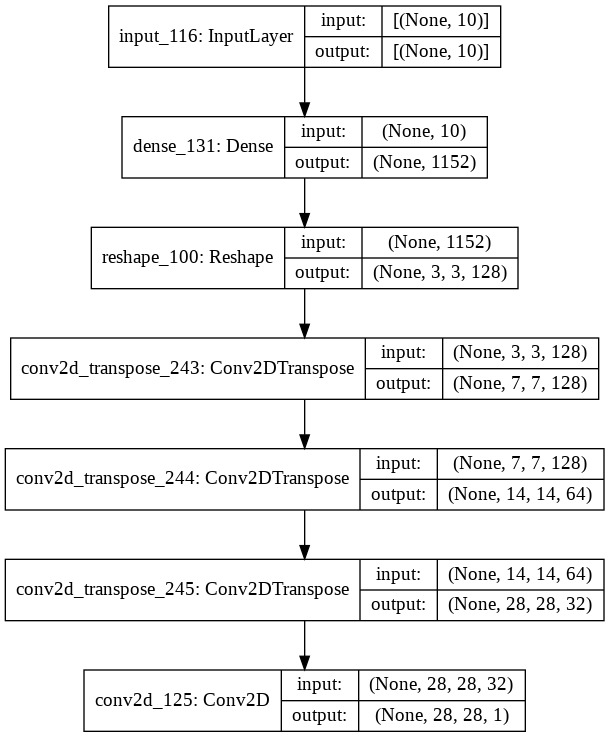

In [233]:
latent_input=layers.Input(shape=(latent_dim,))

x=layers.Dense(np.prod(shape[1:]), activation='relu')(latent_input)
x=layers.Reshape(shape[1:])(x)

### 디코더 모델 변형!!!! 
x=layers.Conv2DTranspose(128,3,strides=2,activation='relu')(x)
x=layers.Conv2DTranspose(64,3,padding='same',strides=2,activation='relu')(x)
x=layers.Conv2DTranspose(32,3,padding='same',strides=2,activation='relu')(x)

output=layers.Conv2D(1,3, padding='same',activation='sigmoid')(x)
decoder=Model(latent_input,output)
decoder.summary()
plot_model(decoder, show_shapes=True)

In [235]:
f_output=decoder(encoder(input_img)[2])  # 최종 출력은 input과 동일한 (28, 28, 1) 3d tensor 출력
vae=Model(input_img, f_output)  
vae.summary()

inference_loss=1+z_log_var-tf.square(z_mean)-tf.exp(z_log_var)
inference_loss=k.sum(inference_loss, axis=-1)*-0.5/(input_img.shape[1]*input_img.shape[1])

vae.add_loss(k.mean(inference_loss))   # add_loss를 이용해 추론손실 정의 
vae.compile(loss='mse', optimizer='rmsprop')

from tensorflow.keras.datasets import mnist

(x_train,_),(x_test,y_test)=mnist.load_data()
image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

history = vae.fit(x_train, x_train, epochs=10, shuffle=True, batch_size=batch_size, validation_data=(x_test,x_test))   # stried 7

Model: "model_127"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_115 (InputLayer)       [(None, 28, 28, 1)]       0         
_________________________________________________________________
model_124 (Functional)       [(None, 10), (None, 10),  130228    
_________________________________________________________________
model_125 (Functional)       (None, 28, 28, 1)         252801    
Total params: 383,029
Trainable params: 383,029
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
3750/3750 [==============================] - 31s 8ms/step - loss: 0.0353 - val_loss: 0.0353
Epoch 2/10
3750/3750 [==============================] - 29s 8ms/step - loss: 0.0352 - val_loss: 0.0352
Epoch 3/10
3750/3750 [==============================] - 29s 8ms/step - loss: 0.0351 - val_loss: 0.0352
Epoch 4/10
3750/3750 [==============================] - 29s 8ms/step - l

수렴이 훨씬 빠르고, 전반적으로 loss가 매우 낮지만 모수의 개수가 너무 많아서 다소 불안정한 학습을 보인다. 

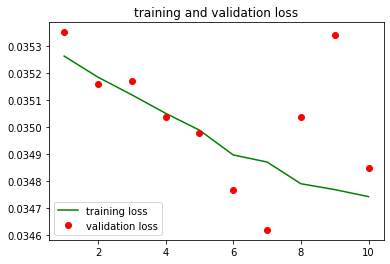

In [237]:
# loss plot
import matplotlib.pyplot as plt
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(1,len(loss)+1)
plt.plot(epochs,loss,'g',label='training loss')
plt.plot(epochs,val_loss,'ro',label='validation loss')
plt.title('training and validation loss')
plt.legend()
plt.show()